# Returns distribution features and tree ensembles

In this third notebook, I am going to include some extra features that represent some characteristics of the distribution of returns of Bitcoin. Additionally, I am also going to test tree ensembles for the quantitative trading problem, which are known to handle non-linear datasets well in general.

## Importing libraries and loading the data

In [1]:
import pandas as pd
import seaborn as sns
import quantstats as qs
import multiprocessing as mp
mp.set_start_method('spawn')

from scipy.stats import jarque_bera
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from trading.backtest import Backtest
from trading.model_selection import GridSearch
from trading.analysis import RocAnalysis

In [2]:
DATASET_FILE = 'data/CMC_BTCUSD_ML_BASELINE_FEATURES.csv'
df = pd.read_csv(DATASET_FILE, header=0, index_col=0, parse_dates=True)
df.tail()

,Open,High,Low,Close,Volume,Market Cap,Return_1,TargetReturn_1,TargetLabel_1,RSI,BCPB,MACD,Return_7,Return_14,Return_21,Return_28
Date,,,,,,,,,,,,,,,,
2023-10-03,27508.251819,27667.192031,27216.001323,27429.979017,1.140781e+10,5.349753e+11,-0.003662,0.013468,1,58.484952,0.874430,0.006194,0.046257,0.008043,0.061805,0.064003
2023-10-04,27429.074995,27826.657948,27248.106247,27799.394096,1.114336e+10,5.422032e+11,0.013468,-0.013795,0,62.254248,0.978212,0.007745,0.054897,0.024598,0.059900,0.079452
2023-10-05,27798.647127,28091.861237,27375.601424,27415.911982,1.187725e+10,5.347474e+11,-0.013795,0.019357,1,56.517655,0.801359,0.008008,0.014594,0.031929,0.033016,0.044806
2023-10-06,27412.122424,28252.537570,27215.552446,27946.596780,1.349239e+10,5.451267e+11,0.019357,0.000796,1,61.768005,0.961178,0.009399,0.038454,0.051432,0.050281,0.078784
2023-10-07,27946.781633,28028.092087,27870.423458,27968.838871,6.553044e+09,5.455899e+11,0.000796,-0.001207,0,61.975241,0.929284,0.010480,0.037115,0.052275,0.052715,0.080058


In [3]:
TARGET_WINDOW = 1
TARGET_COL = f'TargetLabel_{TARGET_WINDOW}'
FEATURES = [c for c in df.columns if c not in ('Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap') and not c.startswith('Target')]
FEATURES

['Return_1',
 'RSI',
 'BCPB',
 'MACD',
 'Return_7',
 'Return_14',
 'Return_21',
 'Return_28']

## Feature engineering: distribution features

First, let's plot the distribution of Bitcoin's returns for the Training and Validation sets.

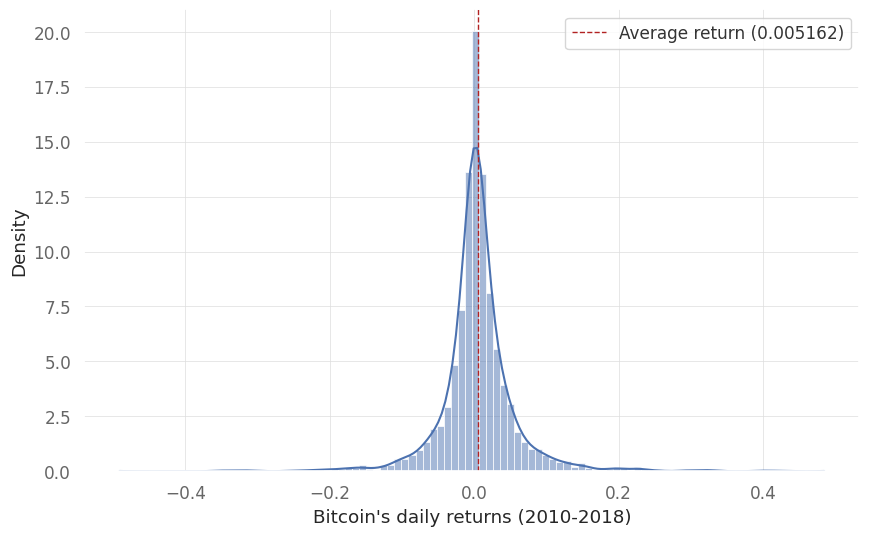

In [4]:
avg_ret = df.loc[:'2018-12-31', 'Return_1'].mean()
ax = sns.histplot(data=df.loc[:'2018-12-31'], x='Return_1', stat='density', bins=100, kde=True)
ax.set_xlabel("Bitcoin's daily returns (2010-2018)")
ax.axvline(avg_ret, linestyle='dashed', color='firebrick', linewidth=1.0, label=f'Average return ({avg_ret:.6f})')
ax.legend()

It can be seen that such a distribution looks like a Normal distribution. However, the assumption of Normal distribution is usually not accurate, since Returns usually have heavier tails than the Normal distribution (which indicates that extreme events are more common than if the returns followed a Normal distribution). We can check that by running a normality test.

In [5]:
jarque_bera(df.loc[:'2018-12-31', 'Return_1'].values)

SignificanceResult(statistic=25444.80288257699, pvalue=0.0)

Jarque-Bera tests whether the skewness and kurtosis of the input sample matches those of a Normal distribution. As explained in [SciPy's documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html), a low p-value for this test rejects the null hypothesis that the sample was drawn from a Normal distribution.

In this notebook, I consider three different types of features to characterize the distribution of Bitcoin's returns: Average Returns, Standard Deviation (or Volatility) and Percentage of days with positive returns.

In [6]:
for w in (7, 14, 21, 28):
    df[f'Avg_Returns_{w}'] = df['Return_1'].rolling(w).mean()
    df[f'SD_Returns_{w}'] = df['Return_1'].rolling(w).std()
    df[f'Days_Positive_Returns_{w}'] = (df['Return_1'] > 0).rolling(w).sum() / w
    FEATURES.extend([f'Avg_Returns_{w}', f'SD_Returns_{w}', f'Days_Positive_Returns_{w}'])

print(f'Total number of features: {len(FEATURES)}')
df.tail()

Total number of features: 20


,Open,High,Low,Close,Volume,Market Cap,Return_1,TargetReturn_1,TargetLabel_1,RSI,...,Days_Positive_Returns_7,Avg_Returns_14,SD_Returns_14,Days_Positive_Returns_14,Avg_Returns_21,SD_Returns_21,Days_Positive_Returns_21,Avg_Returns_28,SD_Returns_28,Days_Positive_Returns_28
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-03,27508.251819,27667.192031,27216.001323,27429.979017,1.140781e+10,5.349753e+11,-0.003662,0.013468,1,58.484952,...,0.571429,0.000678,0.015141,0.428571,0.002944,0.013324,0.52381,0.002316,0.014262,0.464286
2023-10-04,27429.074995,27826.657948,27248.106247,27799.394096,1.114336e+10,5.422032e+11,0.013468,-0.013795,0,62.254248,...,0.571429,0.001847,0.015472,0.500000,0.002857,0.013245,0.52381,0.002834,0.014398,0.500000
2023-10-05,27798.647127,28091.861237,27375.601424,27415.911982,1.187725e+10,5.347474e+11,-0.013795,0.019357,1,56.517655,...,0.428571,0.002348,0.014781,0.500000,0.001635,0.013552,0.47619,0.001666,0.014373,0.464286
2023-10-06,27412.122424,28252.537570,27215.552446,27946.596780,1.349239e+10,5.451267e+11,0.019357,0.000796,1,61.768005,...,0.571429,0.003698,0.015443,0.500000,0.002433,0.014095,0.47619,0.002812,0.014460,0.500000
2023-10-07,27946.781633,28028.092087,27870.423458,27968.838871,6.553044e+09,5.455899e+11,0.000796,-0.001207,0,61.975241,...,0.571429,0.003756,0.015429,0.571429,0.002543,0.014071,0.52381,0.002854,0.014452,0.535714


Let's split the dataset into Training, Validation and Testing, and fit a Logistic Regression model considering all features developed so far (i.e., the new features of this notebook the ones of the [previous notebook](02_BaselineMachineLearningModel.ipynb)).

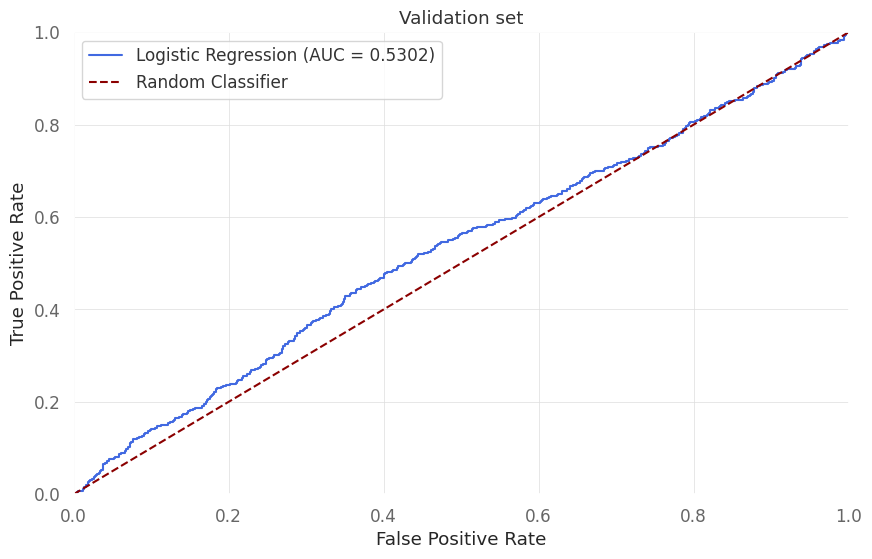

In [7]:
df_train = df.loc[:'2014-12-31'].iloc[:-TARGET_WINDOW].dropna()
df_valid = df.loc['2015-01-01':'2018-12-31'].iloc[:-TARGET_WINDOW].dropna()
df_test = df.loc['2019-01-01':].dropna()

X_train = df_train[FEATURES].values
y_train = df_train[TARGET_COL].values

X_valid = df_valid[FEATURES].values
y_valid = df_valid[TARGET_COL].values

X_test = df_test[FEATURES].values
y_test = df_test[TARGET_COL].values

pipeline = Pipeline([
    ('scaler', StandardScaler(copy=True)),
    ('estimator', LogisticRegression(random_state=42, max_iter=10_000, solver='liblinear'))
])

param_grid = ParameterGrid({
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__C' : [1e-4, 1e-3, 1e-2, 1e-1] + list(map(float, range(1, 21))),
})

grid_search = GridSearch(
    model=pipeline,
    param_grid=param_grid,
    n_jobs=10
)

logit = grid_search.fit(X_train, y_train, X_valid, y_valid)
y_pred = logit.predict_proba(X_valid)[:, 1]

logit_roc_validation = RocAnalysis(y_valid, y_pred, 'Logistic Regression')
logit_roc_validation.plot('Validation set')

In [8]:
logit_best_thr = logit_roc_validation.get_best_thr()
print(f'Logistic Regression best classification threshold: {logit_best_thr:.4f}')
logit_y_valid_proba = logit.predict_proba(X_valid)[:, 1]
logit_y_valid_pred = (logit_y_valid_proba > logit_best_thr).astype(int)
print(classification_report(y_valid, logit_y_valid_pred))

Logistic Regression best classification threshold: 0.5519
              precision    recall  f1-score   support

           0       0.48      0.56      0.52       650
           1       0.59      0.52      0.55       810

    accuracy                           0.53      1460
   macro avg       0.54      0.54      0.53      1460
weighted avg       0.54      0.53      0.54      1460



The in-sample classification results are pretty close to the Baseline Logistic Regression that was developed in the [previous notebook](./02_BaselineMachineLearningModel.ipynb). Let's also check its Sharpe ratio and the out-of-sample results.

<Axes: xlabel='Date'>

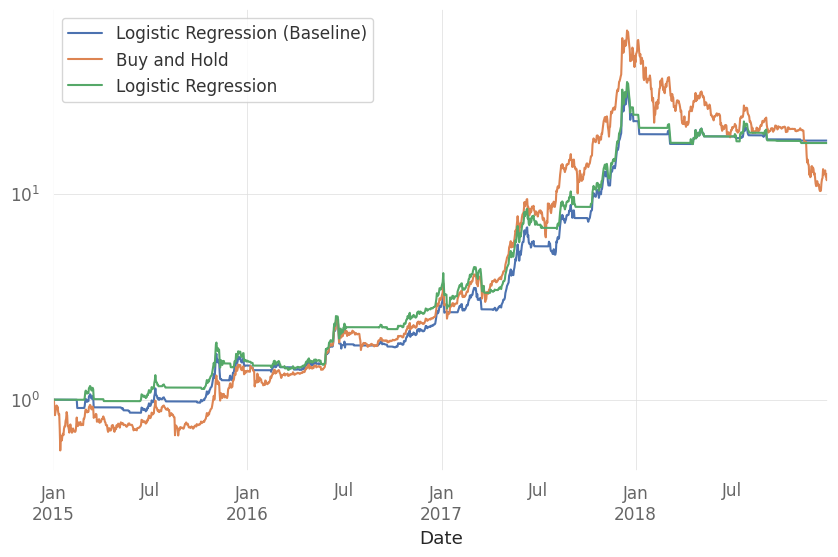

In [9]:
logit_is_backtest = Backtest(
    strategy_name='Logistic Regression',
    price_series=df_valid['Close'],
    signals=pd.Series(logit_y_valid_pred, index=df_valid.index),
    trading_fee=0.001
)
logit_is_backtest.run()

logit_is_df = pd.read_csv('results/logistic_regression_IS.csv', header=0, index_col=0, parse_dates=True)
logit_is_df.columns = ['Logistic Regression (Baseline)', 'Buy and Hold']
logit_is_df = pd.concat([logit_is_df, logit_is_backtest.series_], axis=1)
logit_is_df.plot(logy=True, legend=True)

In [10]:
qs.stats.sharpe(logit_is_df, periods=365).sort_values(ascending=False)

Logistic Regression (Baseline)    1.754663
Logistic Regression               1.695645
Buy and Hold                      1.209229
dtype: float64

In [11]:
logit_y_test_proba = logit.predict_proba(X_test)[:, 1]
logit_y_test_pred = (logit_y_test_proba > logit_best_thr).astype(int)
print(classification_report(y_test, logit_y_test_pred))

              precision    recall  f1-score   support

           0       0.51      0.62      0.56       854
           1       0.53      0.42      0.47       887

    accuracy                           0.52      1741
   macro avg       0.52      0.52      0.51      1741
weighted avg       0.52      0.52      0.51      1741



<Axes: xlabel='Date'>

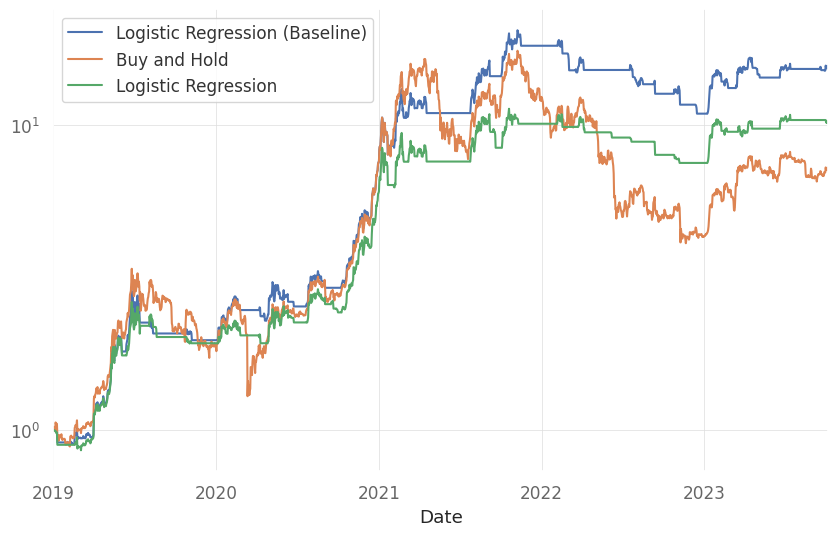

In [12]:
logit_oos_backtest = Backtest(
    strategy_name='Logistic Regression',
    price_series=df_test['Close'],
    signals=pd.Series(logit_y_test_pred, index=df_test.index),
    trading_fee=0.001
)
logit_oos_backtest.run()

logit_oos_df = pd.read_csv('results/logistic_regression_OOS.csv', header=0, index_col=0, parse_dates=True)
logit_oos_df.columns = ['Logistic Regression (Baseline)', 'Buy and Hold']
logit_oos_df = pd.concat([logit_oos_df, logit_oos_backtest.series_], axis=1)
logit_oos_df.plot(logy=True, legend=True)

In [13]:
qs.stats.sharpe(logit_oos_df, periods=365).sort_values(ascending=False)

Logistic Regression (Baseline)    1.531231
Logistic Regression               1.353135
Buy and Hold                      0.959340
dtype: float64

The Logistic Regression that incorporates the new features achieved worse results with respect to the Sharpe ratio when compared to our Baseline Logistic Regression.

## Tree ensembles

Next, I am going to run two ensemble algorithms, Random Forests and Extra Trees, which are better at handling non-linear data when compared to Logistic Regression. They are similar, except for the following differences:

* In Random Forests, each tree is fitted on a bootstrap aggregated sample of the original dataset, while in Extra Trees, each tree is fitted on the original dataset.
* In Random Forests, a node is defined as the best split that can be derived from a random subset of features, while in Extra Trees, a node is defined as the best split obtained from a subset of random splits.

These two algorithms usually work well with their default hyparameters. For such a reason, I consider two versions of each one: (i) using default hyperparameters and (ii) using hyperparameter optimization.

### Random Forest

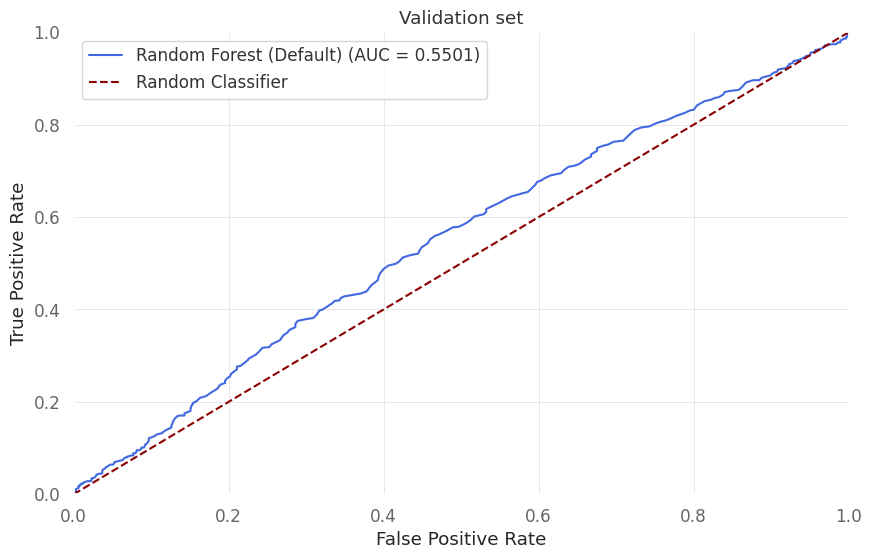

In [14]:
default_random_forest = RandomForestClassifier(n_estimators=500, random_state=42)
default_random_forest.fit(X_train, y_train)
y_pred = default_random_forest.predict_proba(X_valid)[:, 1]

default_random_forest_roc_validation = RocAnalysis(y_valid, y_pred, 'Random Forest (Default)')
default_random_forest_roc_validation.plot('Validation set')

In [15]:
default_random_forest_best_thr = default_random_forest_roc_validation.get_best_thr()
print(f'Random Forest (Default) best classification threshold: {default_random_forest_best_thr:.4f}')
default_random_forest_y_valid_proba = default_random_forest.predict_proba(X_valid)[:, 1]
default_random_forest_y_valid_pred = (default_random_forest_y_valid_proba > default_random_forest_best_thr).astype(int)
print(classification_report(y_valid, default_random_forest_y_valid_pred))

default_random_forest_is_backtest = Backtest(
    strategy_name='Random Forest (Default)',
    price_series=df_valid['Close'],
    signals=pd.Series(default_random_forest_y_valid_pred, index=df_valid.index),
    trading_fee=0.001
)
_ = default_random_forest_is_backtest.run()

Random Forest (Default) best classification threshold: 0.5380
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       650
           1       0.60      0.56      0.58       810

    accuracy                           0.55      1460
   macro avg       0.55      0.55      0.55      1460
weighted avg       0.55      0.55      0.55      1460



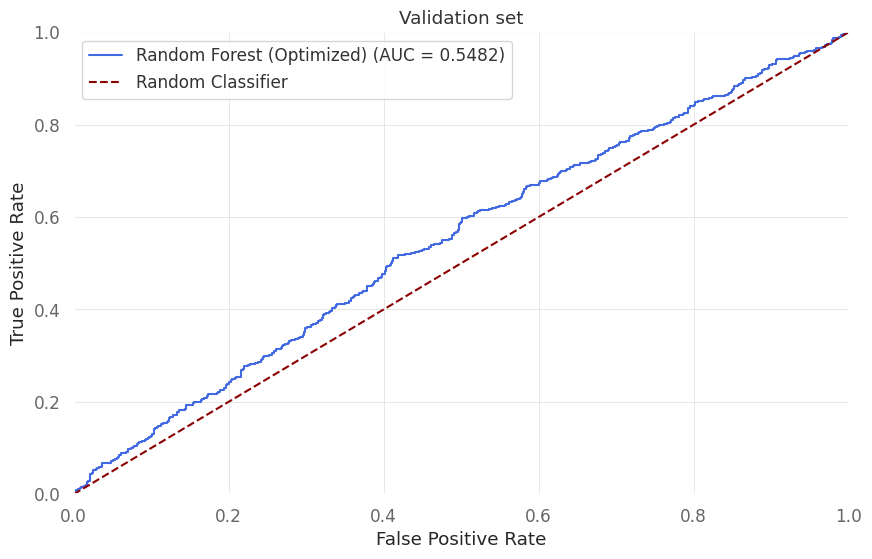

In [16]:
random_forest = RandomForestClassifier(n_estimators=500, random_state=42)

param_grid = ParameterGrid({
    'min_samples_leaf' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10],
    'max_features' : list(range(1, X_train.shape[1] // 2)),
})

grid_search = GridSearch(
    model=random_forest,
    param_grid=param_grid,
    n_jobs=10
)

random_forest = grid_search.fit(X_train, y_train, X_valid, y_valid)
y_pred = random_forest.predict_proba(X_valid)[:, 1]

random_forest_roc_validation = RocAnalysis(y_valid, y_pred, 'Random Forest (Optimized)')
random_forest_roc_validation.plot('Validation set')

In [17]:
random_forest_best_thr = random_forest_roc_validation.get_best_thr()
print(f'Random Forest (Optimized) best classification threshold: {random_forest_best_thr:.4f}')
random_forest_y_valid_proba = random_forest.predict_proba(X_valid)[:, 1]
random_forest_y_valid_pred = (random_forest_y_valid_proba > random_forest_best_thr).astype(int)
print(classification_report(y_valid, random_forest_y_valid_pred))

random_forest_is_backtest = Backtest(
    strategy_name='Random Forest (Optimized)',
    price_series=df_valid['Close'],
    signals=pd.Series(random_forest_y_valid_pred, index=df_valid.index),
    trading_fee=0.001
)
_ = random_forest_is_backtest.run()

Random Forest (Optimized) best classification threshold: 0.5424
              precision    recall  f1-score   support

           0       0.49      0.58      0.53       650
           1       0.61      0.52      0.56       810

    accuracy                           0.55      1460
   macro avg       0.55      0.55      0.54      1460
weighted avg       0.55      0.55      0.55      1460



### Extra Trees

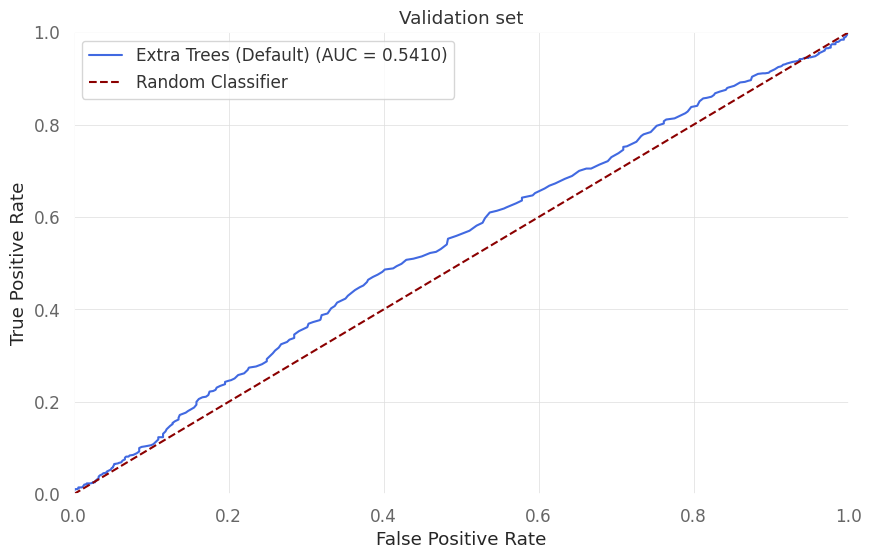

In [18]:
default_extra_trees = ExtraTreesClassifier(n_estimators=500, random_state=42)
default_extra_trees.fit(X_train, y_train)
y_pred = default_extra_trees.predict_proba(X_valid)[:, 1]

default_extra_trees_roc_validation = RocAnalysis(y_valid, y_pred, 'Extra Trees (Default)')
default_extra_trees_roc_validation.plot('Validation set')

In [19]:
default_extra_trees_best_thr = default_extra_trees_roc_validation.get_best_thr()
print(f'Extra Trees (Default) best classification threshold: {default_extra_trees_best_thr:.4f}')
default_extra_trees_y_valid_proba = default_extra_trees.predict_proba(X_valid)[:, 1]
default_extra_trees_y_valid_pred = (default_extra_trees_y_valid_proba > default_extra_trees_best_thr).astype(int)
print(classification_report(y_valid, default_extra_trees_y_valid_pred))

default_extra_trees_backtest = Backtest(
    strategy_name='Extra Trees (Default)',
    price_series=df_valid['Close'],
    signals=pd.Series(default_extra_trees_y_valid_pred, index=df_valid.index),
    trading_fee=0.001
)
_ = default_extra_trees_backtest.run()

Extra Trees (Default) best classification threshold: 0.5460
              precision    recall  f1-score   support

           0       0.48      0.60      0.54       650
           1       0.60      0.48      0.53       810

    accuracy                           0.53      1460
   macro avg       0.54      0.54      0.53      1460
weighted avg       0.55      0.53      0.53      1460



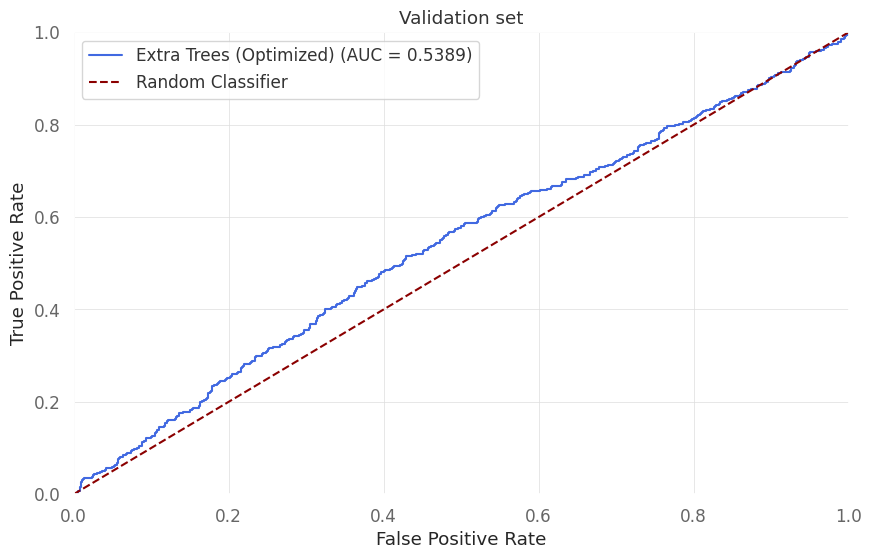

In [20]:
extra_trees = ExtraTreesClassifier(n_estimators=500, random_state=42)

param_grid = ParameterGrid({
    'min_samples_leaf' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10],
    'max_features' : list(range(1, df_train.shape[1] // 2 + 1)),
})

grid_search = GridSearch(
    model=extra_trees,
    param_grid=param_grid,
    n_jobs=10
)

extra_trees = grid_search.fit(X_train, y_train, X_valid, y_valid)
y_pred = extra_trees.predict_proba(X_valid)[:, 1]

extra_trees_roc_validation = RocAnalysis(y_valid, y_pred, 'Extra Trees (Optimized)')
extra_trees_roc_validation.plot('Validation set')

In [21]:
extra_trees_best_thr = extra_trees_roc_validation.get_best_thr()
print(f'Extra Trees best classification threshold: {extra_trees_best_thr:.4f}')
extra_trees_y_valid_proba = extra_trees.predict_proba(X_valid)[:, 1]
extra_trees_y_valid_pred = (extra_trees_y_valid_proba > extra_trees_best_thr).astype(int)
print(classification_report(y_valid, extra_trees_y_valid_pred))

extra_trees_backtest = Backtest(
    strategy_name='Extra Trees (Optimized)',
    price_series=df_valid['Close'],
    signals=pd.Series(extra_trees_y_valid_pred, index=df_valid.index),
    trading_fee=0.001
)
_ = extra_trees_backtest.run()

Extra Trees best classification threshold: 0.5415
              precision    recall  f1-score   support

           0       0.48      0.57      0.52       650
           1       0.60      0.51      0.55       810

    accuracy                           0.54      1460
   macro avg       0.54      0.54      0.54      1460
weighted avg       0.55      0.54      0.54      1460



## Comparing all ML models in-sample

<Axes: xlabel='Date'>

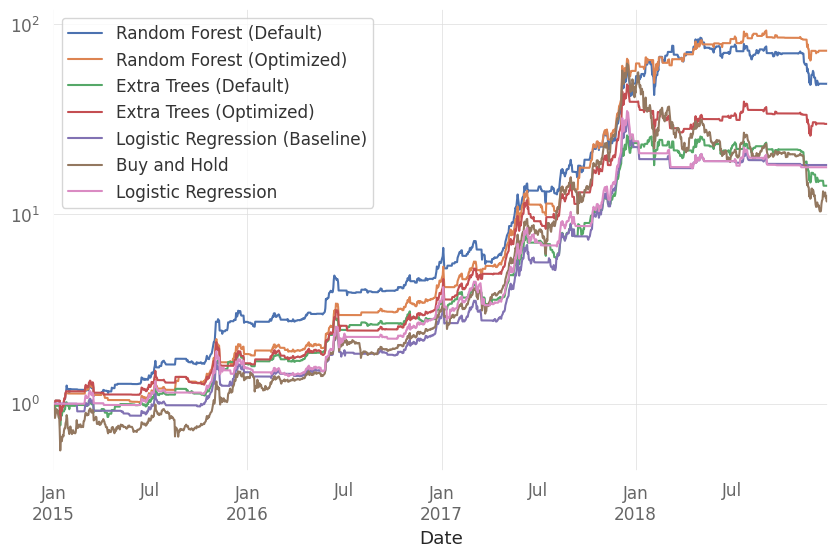

In [22]:
results_is_df = pd.concat([
    default_random_forest_is_backtest.series_,
    random_forest_is_backtest.series_,
    default_extra_trees_backtest.series_,
    extra_trees_backtest.series_,
    logit_is_df
], axis=1)
results_is_df.plot(logy=True, legend=True)

In [23]:
is_sharpe = qs.stats.sharpe(results_is_df, periods=365).sort_values(ascending=False)
is_sharpe

Random Forest (Optimized)         2.268794
Random Forest (Default)           2.015367
Extra Trees (Optimized)           1.875468
Logistic Regression (Baseline)    1.754663
Logistic Regression               1.695645
Extra Trees (Default)             1.533821
Buy and Hold                      1.209229
dtype: float64

In [24]:
results_is_df.to_csv('results/ml_models_IS.csv')

## Testing the ensemble models out-of-sample

In [25]:
default_random_forest_y_test_proba = default_random_forest.predict_proba(X_test)[:, 1]
default_random_forest_y_test_pred = (default_random_forest_y_test_proba > default_random_forest_best_thr).astype(int)
print(classification_report(y_test, default_random_forest_y_test_pred))

default_random_forest_oos_backtest = Backtest(
    strategy_name='Random Forest (Default)',
    price_series=df_test['Close'],
    signals=pd.Series(default_random_forest_y_test_pred, index=df_test.index),
    trading_fee=0.001
)
_ = default_random_forest_oos_backtest.run()

              precision    recall  f1-score   support

           0       0.50      0.61      0.55       854
           1       0.53      0.42      0.47       887

    accuracy                           0.51      1741
   macro avg       0.52      0.52      0.51      1741
weighted avg       0.52      0.51      0.51      1741



In [26]:
random_forest_y_test_proba = random_forest.predict_proba(X_test)[:, 1]
random_forest_y_test_pred = (random_forest_y_test_proba > random_forest_best_thr).astype(int)
print(classification_report(y_test, random_forest_y_test_pred))

random_forest_oos_backtest = Backtest(
    strategy_name='Random Forest (Optimized)',
    price_series=df_test['Close'],
    signals=pd.Series(random_forest_y_test_pred, index=df_test.index),
    trading_fee=0.001
)
_ = random_forest_oos_backtest.run()

              precision    recall  f1-score   support

           0       0.51      0.66      0.58       854
           1       0.55      0.40      0.46       887

    accuracy                           0.53      1741
   macro avg       0.53      0.53      0.52      1741
weighted avg       0.53      0.53      0.52      1741



In [27]:
default_extra_trees_y_test_proba = default_extra_trees.predict_proba(X_test)[:, 1]
default_extra_trees_y_test_pred = (default_extra_trees_y_test_proba > default_extra_trees_best_thr).astype(int)
print(classification_report(y_test, default_extra_trees_y_test_pred))

default_extra_trees_oos_backtest = Backtest(
    strategy_name='Extra Trees (Default)',
    price_series=df_test['Close'],
    signals=pd.Series(default_extra_trees_y_test_pred, index=df_test.index),
    trading_fee=0.001
)
_ = default_extra_trees_oos_backtest.run()

              precision    recall  f1-score   support

           0       0.51      0.66      0.58       854
           1       0.54      0.38      0.45       887

    accuracy                           0.52      1741
   macro avg       0.52      0.52      0.51      1741
weighted avg       0.53      0.52      0.51      1741



In [28]:
extra_trees_y_test_proba = extra_trees.predict_proba(X_test)[:, 1]
extra_trees_y_test_pred = (extra_trees_y_test_proba > extra_trees_best_thr).astype(int)
print(classification_report(y_test, extra_trees_y_test_pred))

extra_trees_oos_backtest = Backtest(
    strategy_name='Extra Trees (Optimized)',
    price_series=df_test['Close'],
    signals=pd.Series(extra_trees_y_test_pred, index=df_test.index),
    trading_fee=0.001
)
_ = extra_trees_oos_backtest.run()

              precision    recall  f1-score   support

           0       0.51      0.66      0.58       854
           1       0.54      0.39      0.45       887

    accuracy                           0.52      1741
   macro avg       0.53      0.52      0.51      1741
weighted avg       0.53      0.52      0.51      1741



<Axes: xlabel='Date'>

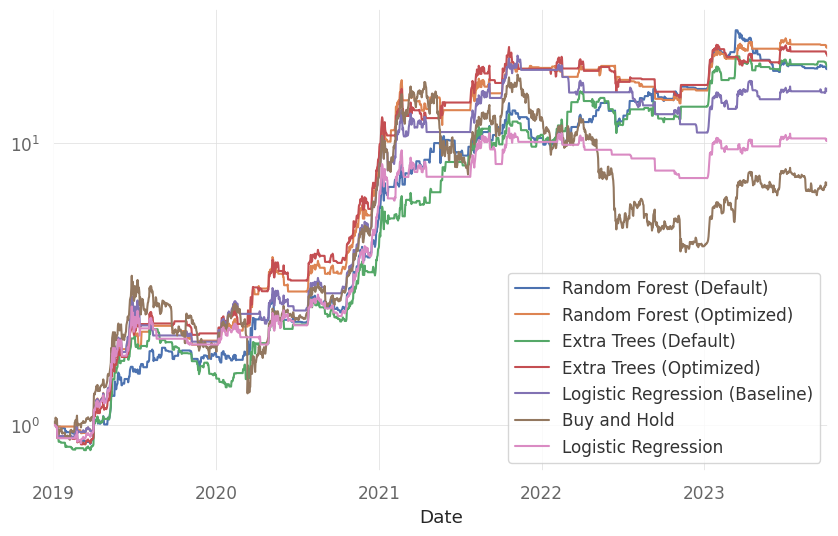

In [29]:
results_df = pd.concat([
    default_random_forest_oos_backtest.series_,
    random_forest_oos_backtest.series_,
    default_extra_trees_oos_backtest.series_,
    extra_trees_oos_backtest.series_,
    logit_oos_df
], axis=1)

results_df.plot(logy=True, legend=True)

In [30]:
oos_sharpe = qs.stats.sharpe(results_df, periods=365).sort_values(ascending=False)
oos_sharpe

Random Forest (Optimized)         1.670691
Extra Trees (Optimized)           1.651760
Extra Trees (Default)             1.645750
Random Forest (Default)           1.598856
Logistic Regression (Baseline)    1.531231
Logistic Regression               1.353135
Buy and Hold                      0.959340
dtype: float64

Let's plot only the optimized models, to better visualize their results when compared to the baseline model and the Buy and Hold strategy.

<Axes: xlabel='Date'>

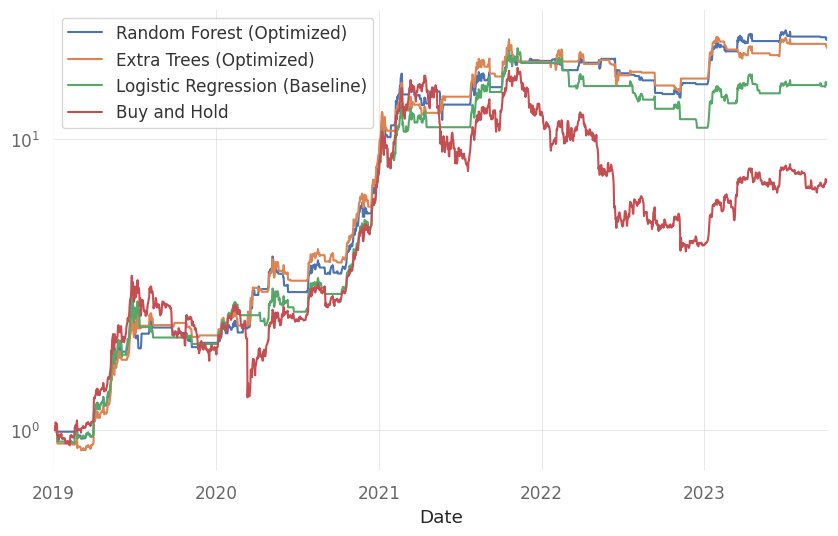

In [31]:
cols_to_plot = [
    'Random Forest (Optimized)',
    'Extra Trees (Optimized)',
    'Logistic Regression (Baseline)',
    'Buy and Hold'
]

results_df[cols_to_plot].plot(logy=True, legend=True)

Finally, checking the max drawdown of each model.

In [32]:
qs.stats.max_drawdown(results_df).sort_values(ascending=False) * 100.0

Random Forest (Optimized)        -31.418930
Random Forest (Default)          -31.699006
Logistic Regression              -33.640701
Extra Trees (Optimized)          -33.760620
Extra Trees (Default)            -37.899645
Logistic Regression (Baseline)   -46.797087
Buy and Hold                     -76.634565
dtype: float64

In [33]:
results_df.to_csv('results/ml_models_OOS.csv')